# Seasonality analysis

In [99]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_datareader import data as pdr
from statsmodels.tsa.seasonal import MSTL
import os.path
import os
from datetime import datetime
from IPython.display import display, Markdown, Latex





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD



# set maximum number of years to analyze
max_num_of_years = 5


def D(text: str):
    display(Markdown(text))



def splitYears(frame):
    frameToReturn = pd.DataFrame()
    numOfYears = 0
    for year in sorted(list(set(frame.index.year)), reverse=True)[1:-1]:
        numOfYears += 1
        if numOfYears > max_num_of_years:
            break
        curYearValues = frame[str(year) + '-01-01':str(year) + '-12-31'].values
        if curYearValues.size == 366:
            curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
        frameToReturn[str(year)] = curYearValues
    return frameToReturn






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Years to analysis**: {datetime.now().year-1} until earliest {datetime.now().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EUNL.DE

* **Years to analysis**: 2022 until earliest 2018

In [100]:
dirname = '.downloads'
filename = f'{dirname}{os.path.sep}{symbol}_{datetime.now().year}.csv'

os.makedirs(dirname, exist_ok=True)

is_downloaded = False

if not os.path.isfile(filename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(filename)
    is_downloaded = True
else:
    df = pd.read_csv(filename, parse_dates=['Date'], index_col=['Date'])



D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')
if is_downloaded:
    D(f'* Data downloaded from internet')
D(f'* Filename: {filename}')
D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _EUNL.DE_

* From 25.09.09 to 21.06.23

* Filename: .downloads/EUNL.DE_2023.csv

## Statistics:

             Close
count  3489.000000
mean     41.642401
std      17.943576
min      16.510000
25%      24.820000
50%      39.279999
75%      53.068001
max      79.529999


## Data:

                Close
Date                 
2009-09-25  17.209999
2009-09-28  17.209999
2009-09-29  17.209999
2009-09-30  17.209999
2009-10-01  17.209999
...               ...
2023-06-15  76.896004
2023-06-16  77.213997
2023-06-19  76.758003
2023-06-20  76.393997
2023-06-21  76.010002

[3489 rows x 1 columns]


In [105]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

resultDf = pd.DataFrame()







resultDf = splitYears(df, df['Close'])

resultMean = resultDf.mean(axis=1)
resultMin = resultDf.min(axis=1)
resultMax = resultDf.max(axis=1)
resultDf['mean'] = resultMean
resultDf['min'] = resultMin
resultDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
resultDf['date'] = range
resultDf = resultDf.set_index('date')

# resultDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
resultDf

KeyError: 'Close'

In [104]:
decompose = MSTL(df['Close'], periods=365)
decompose = decompose.fit()

resultDf = splitYears(decompose.seasonal)

#numOfYears = 0
#for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
#    numOfYears += 1
#    if numOfYears > max_num_of_years:
#        break
#    curYearValues = decompose.seasonal[str(year) + '-01-01':str(year) + '-12-31'].values
#    if curYearValues.size == 366:
#        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
#    resultDf['seasonal-' + str(year)] = curYearValues


#D('## Seasonal decomposition')
#resultDf
decompose.seasonal

TypeError: splitYears() takes 1 positional argument but 2 were given

<Axes: title={'center': 'Trend'}, xlabel='Date'>

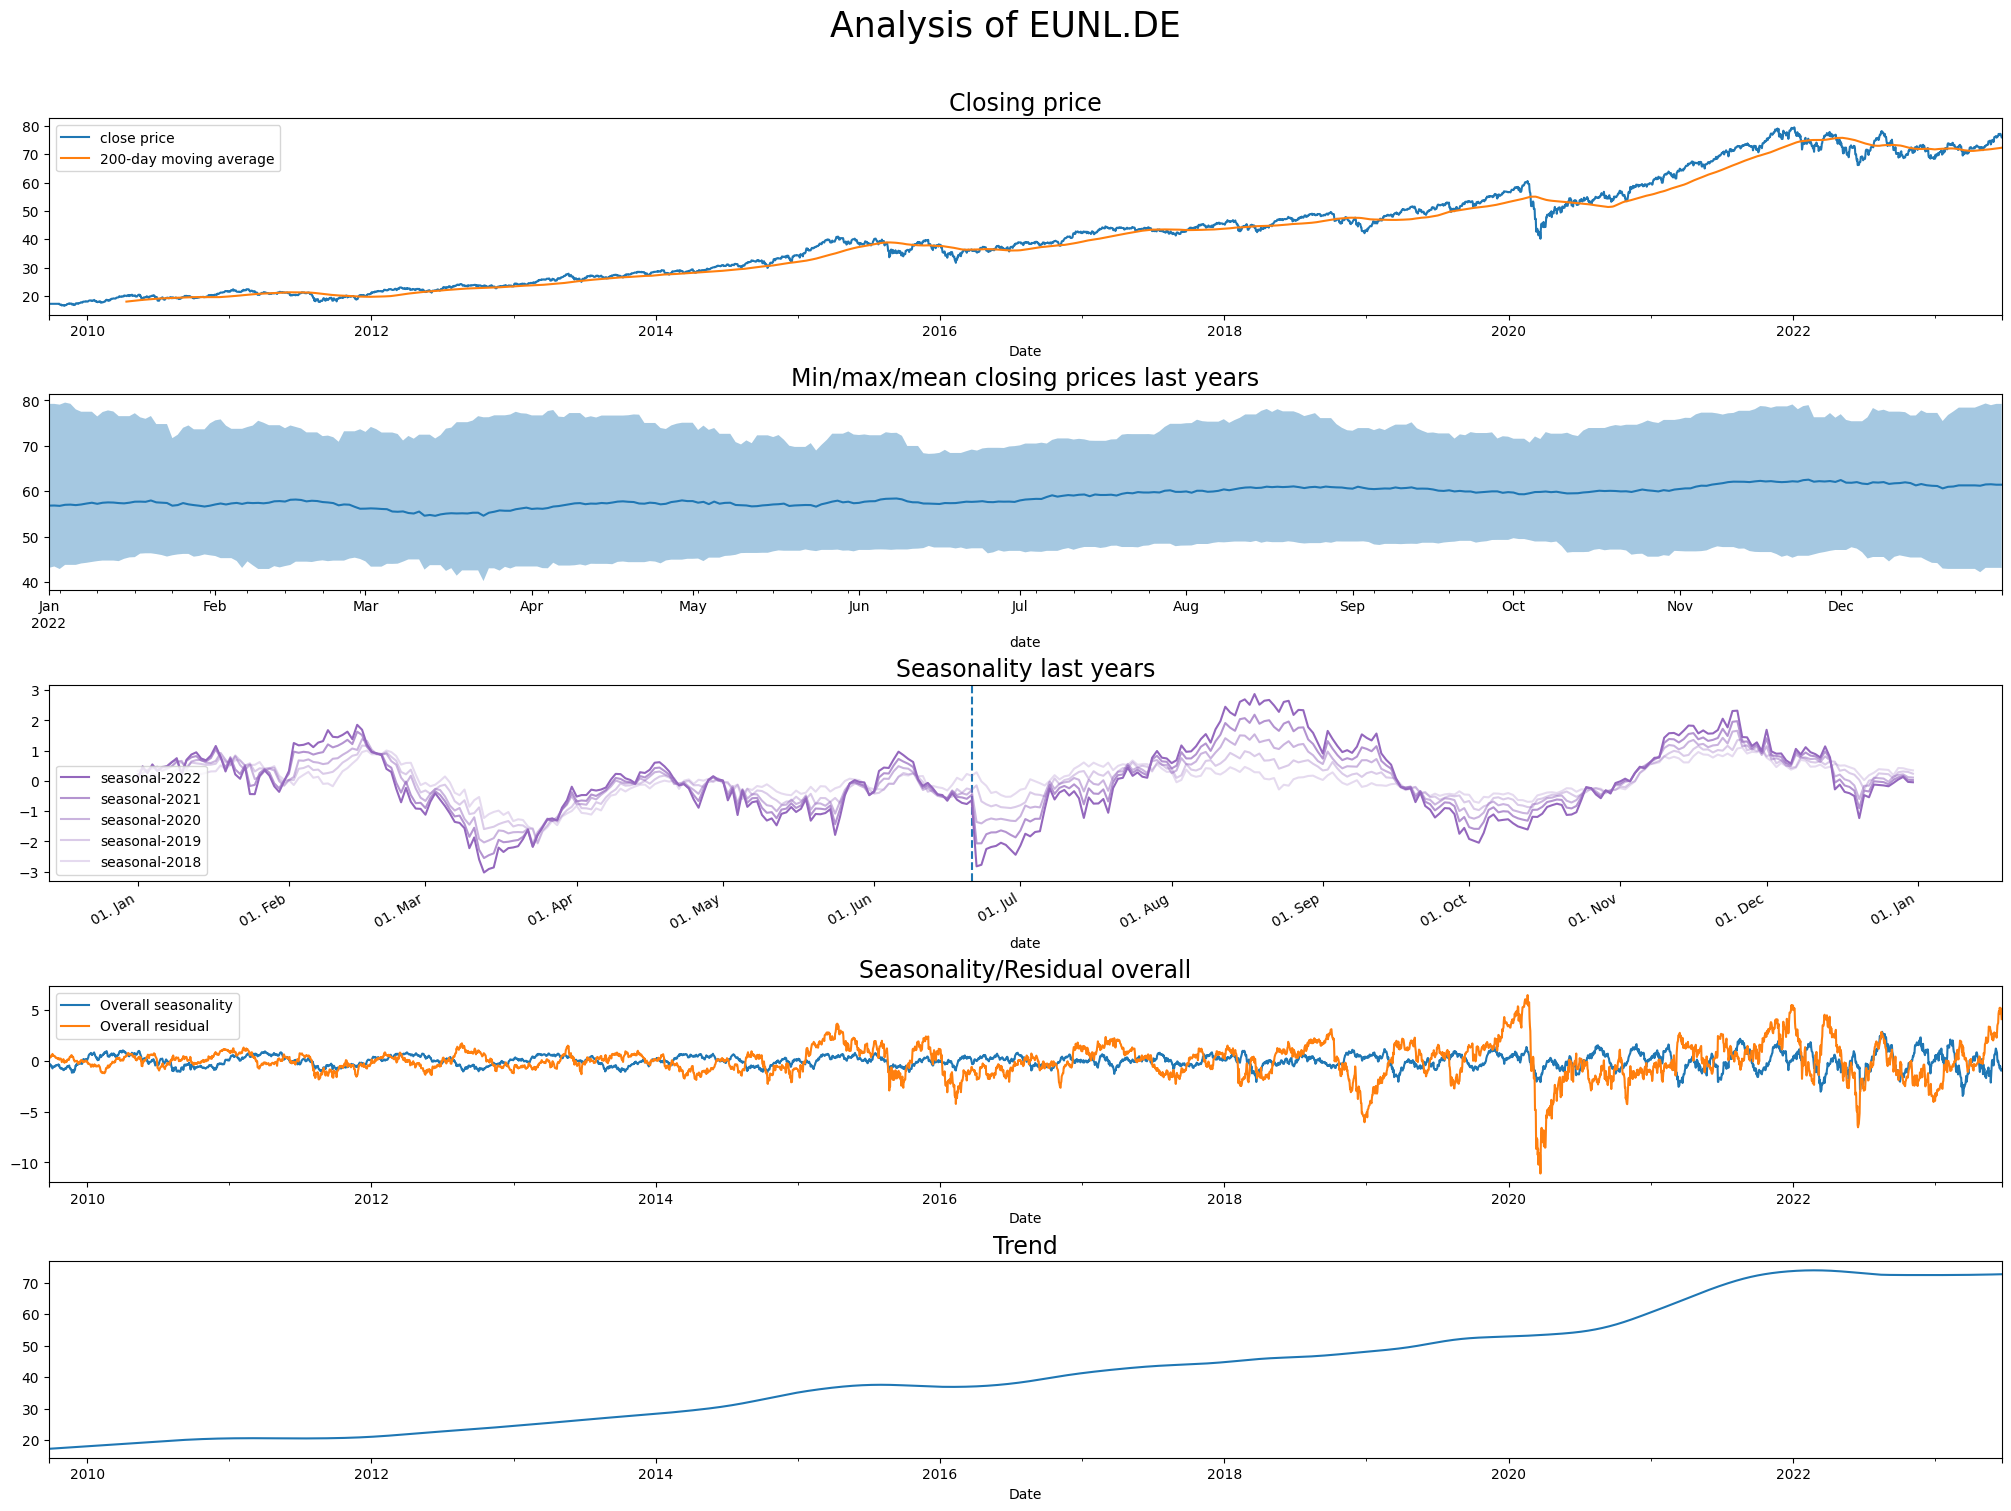

In [92]:
plt.figure(figsize=(20, 15), layout='constrained')
plt.suptitle(f'Analysis of {symbol}\n', fontsize=25)

plt.subplot(511)
plt.title('Closing price', fontsize=17)
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average')

plt.subplot(512)
plt.title('Min/max/mean closing prices last years', fontsize=17)
plt.fill_between(resultDf.index, resultDf['min'], resultDf['max'], alpha=0.4)
resultDf['mean'].plot()

plt.subplot(513)
plt.title('Seasonality last years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d. %b"))
alpha_value = 1
for col in resultDf.columns:
    if col.startswith('seasonal-'):
        resultDf[col].plot(legend=True, color='tab:purple', alpha=alpha_value)
        alpha_value = alpha_value * 0.7

plt.subplot(514)
plt.title('Seasonality/Residual overall', fontsize=17)
decompose.seasonal.plot(legend=True, label='Overall seasonality')
decompose.resid.plot(legend=True, label='Overall residual')

plt.subplot(515)
plt.title('Trend', fontsize=17)
decompose.trend.plot()